In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from cartopy import crs as ccrs
import cartopy.feature as cfeature
import datetime
import s3fs

In [2]:
fs = s3fs.S3FileSystem(anon=True)

Set the date and hour for the data of interest: 

In [3]:
year = 2023
month = 3
day = 31
hour = 22

julian_day = datetime.datetime(year, month, day).strftime('%j')
print(julian_day)

090


Product chosen: ABI-L2-MCMIPM - Advanced Baseline Imager Level 2 Cloud and Moisture Imagery Mesoscale

In [4]:
bucket = 'noaa-goes16'
product = 'ABI-L2-MCMIPM'

data_path = bucket + '/' + product + '/'  + str(year) + '/' + julian_day + '/' + str(hour).zfill(2)

files = fs.ls(data_path)

# for file in files:
#    print(file.split('/')[-1])

M1 refers to mesoscale sector 1, M6 refers to scan mode 6.

Select the start and end times within the hour selected earlier: 

In [5]:
observation_start = '2215'
observation_end = '2216'
product_name = 'ABI-L2-MCMIPM1-M6'

matches = [file for file in files if (file.split('/')[-1].split('_')[3][8:12] >= observation_start and file.split('/')[-1].split('_')[3][8:12] <= observation_end and file.split('/')[-1].split('_')[1] == product_name)]

for match in matches:
    print(match.split('/')[-1])
    print('Approximate file size (MB):', round((fs.size(match)/1.0E6), 2))

OR_ABI-L2-MCMIPM1-M6_G16_s20230902215247_e20230902215318_c20230902215397.nc
Approximate file size (MB): 5.37
OR_ABI-L2-MCMIPM1-M6_G16_s20230902216247_e20230902216318_c20230902216397.nc
Approximate file size (MB): 5.37


Open the first file of the range selected: 

In [6]:
remote_file = fs.open(matches[0], mode='rb')
ds = xr.open_dataset(remote_file, engine='h5netcdf')

ABI Cloud and Moisture Imagery reflectance factor for each channel:

In [7]:
ch1 = ds.CMI_C01 #blue (vis)
ch2 = ds.CMI_C02 #red (vis)
ch3 = ds.CMI_C03 #veggie (near-ir)

Calculate the green color for the RGB:

In [8]:
green = 0.45*ch2 + 0.1*ch3 + 0.45*ch1

Create the RGB:

In [9]:
tc_RGB = np.dstack([ch2, green, ch1])

Adding a gamma correction to improve color:

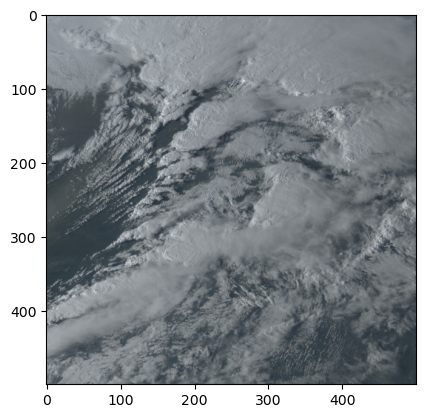

In [10]:
gamma = 2
tc_RGB_gamma = np.power(tc_RGB, 1/gamma)

plt.figure()
plt.imshow(tc_RGB_gamma)
plt.show()

In [14]:
np.shape(tc_RGB_gamma)

(500, 500, 3)

In [22]:
ds.goes_imager_projection

<xarray.DataArray 'goes_imager_projection' ()>
array(-2147483647, dtype=int32)
Coordinates:
    t        datetime64[ns] 2023-03-31T22:15:28.293678976
    y_image  float32 0.10304
    x_image  float32 -0.03192
Attributes:
    long_name:                       GOES-R ABI fixed grid projection
    grid_mapping_name:               geostationary
    perspective_point_height:        35786023.0
    semi_major_axis:                 6378137.0
    semi_minor_axis:                 6356752.31414
    inverse_flattening:              298.2572221
    latitude_of_projection_origin:   0.0
    longitude_of_projection_origin:  -75.0
    sweep_angle_axis:                x

In [ ]:
lat, lon = calculate_abi_lat_lon(ds)

In [ ]:
remote_file.close()
ds.close()

Running RGB creation on the remote side: 

In [16]:
def calculate_abi_lat_lon(ds):
    
    # Read in GOES ABI fixed grid projection variables and constants
    x_coordinate_1d = ds.x  # E/W scanning angle in radians
    y_coordinate_1d = ds.y  # N/S elevation angle in radians
    projection_info = ds.goes_imager_projection  # ABI fixed grid contstants
    lon_origin = projection_info.longitude_of_projection_origin
    H = projection_info.perspective_point_height+projection_info.semi_major_axis
    r_eq = projection_info.semi_major_axis
    r_pol = projection_info.semi_minor_axis
    
    # Create 2D coordinate matrices from 1D coordinate vectors
    x_coordinate_2d, y_coordinate_2d = np.meshgrid(x_coordinate_1d, y_coordinate_1d)
    
    # Equations to calculate latitude and longitude
    lambda_0 = (lon_origin*np.pi)/180.0  
    a_var = np.power(np.sin(x_coordinate_2d),2.0) + (np.power(np.cos(x_coordinate_2d),2.0)*(np.power(np.cos(y_coordinate_2d),2.0)+(((r_eq*r_eq)/(r_pol*r_pol))*np.power(np.sin(y_coordinate_2d),2.0))))
    b_var = -2.0*H*np.cos(x_coordinate_2d)*np.cos(y_coordinate_2d)
    c_var = (H**2.0)-(r_eq**2.0)
    r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)
    s_x = r_s*np.cos(x_coordinate_2d)*np.cos(y_coordinate_2d)
    s_y = - r_s*np.sin(x_coordinate_2d)
    s_z = r_s*np.cos(x_coordinate_2d)*np.sin(y_coordinate_2d)
    
    lat = (180.0/np.pi)*(np.arctan(((r_eq*r_eq)/(r_pol*r_pol))*((s_z/np.sqrt(((H-s_x)*(H-s_x))+(s_y*s_y))))))
    lon = (lambda_0 - np.arctan(s_y/(H-s_x)))*(180.0/np.pi)
    

In [ ]:
with fs.open(matches[0], mode='rb') as remote_file:
    with xr.open_dataset(remote_file, engine='h5netcdf') as ds:
        
        ch1 = ds.CMI_C01 #blue (vis)
        ch2 = ds.CMI_C02 #red (vis)
        ch3 = ds.CMI_C03 #veggie (near-ir)
        
        green = 0.45*ch2 + 0.1*ch3 + 0.45*ch1
        
        tc_RGB = np.dstack([ch2, green, ch1])
        
        gamma = 2
        tc_RGB_gamma = np.power(tc_RGB, 1/gamma)
        
        #lat, lon = calculate_abi_lat_lon(ds)
        
        projection=ccrs.PlateCarree()
        fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
        #levels = np.linspace(0, 6, 11)
        
        #ax.set_extent([np.nanmin(lon), np.nanmax(lon), np.nanmin(lat), np.nanmax(lat)])
        plt.imshow(tc_RGB_gamma)

        #c=ax.contourf(lon, lat, tc_RGB_gamma)
        #clb=plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
        ax.set_title('True Color RGB')

        ax.coastlines(resolution='50m', color='black', linewidth=1)
        ax.add_feature(cfeature.STATES)